# LangGraph Basics


In this notebook we'll learn the foundational LangGraph primitives from first principles:
1. `StateGraph`, `TypedDict`, nodes, and edges
2. The `add_messages` reducer
3. Conditional routing
4. Memory with checkpoints
5. Visualizing your graph

In [1]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)
# Expects: OPENROUTER_API_KEY, SERPAPI_API_KEY
# Optional: LANGSMITH_API_KEY

True

## 1. Hello World — A minimal graph

The absolute minimum LangGraph program: two nodes, linear flow, a simple `TypedDict` state.

Key concepts introduced:
- `StateGraph` — the graph builder
- `add_node` — registers a function as a graph node
- `add_edge` — connects nodes in sequence
- `compile` — finalizes the graph into a runnable
- `invoke` — executes the graph with an initial state

In [2]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END


class SimpleState(TypedDict):
    text: str


def node_a(state: SimpleState) -> dict:
    return {"text": state["text"] + " Hello"}


def node_b(state: SimpleState) -> dict:
    return {"text": state["text"] + " World"}


graph = StateGraph(SimpleState)
graph.add_node("greeter", node_a)
graph.add_node("responder", node_b)

graph.add_edge(START, "greeter")
graph.add_edge("greeter", "responder")
graph.add_edge("responder", END)

app = graph.compile()

result = app.invoke({"text": ">>>"})
print(result)  # {"text": ">>> Hello World"}

{'text': '>>> Hello World'}


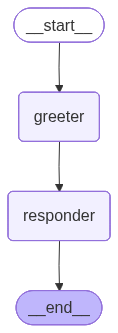

In [3]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

Notice: each node returns a **partial state update**. LangGraph merges it into the full state. By default, returned keys **overwrite** the existing values.

## 2. State and the `add_messages` reducer

For chat agents, we need messages to **accumulate** rather than overwrite. That's what reducers do.

The `add_messages` reducer is the most important one — it appends new messages to the existing list instead of replacing it. This is the key mental model for building conversation agents.

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph.message import add_messages


# Without reducer: messages would OVERWRITE on each node return
# With add_messages: messages ACCUMULATE
class ChatState(TypedDict):
    messages: Annotated[list, add_messages]


def echo_bot(state: ChatState) -> dict:
    """Simple echo bot — responds with what you said."""
    last_msg = state["messages"][-1].content
    return {"messages": [AIMessage(content=f"You said: {last_msg}")]}


graph = StateGraph(ChatState)
graph.add_node("bot", echo_bot)
graph.add_edge(START, "bot")
graph.add_edge("bot", END)

app = graph.compile()

# First invocation
result = app.invoke({"messages": [HumanMessage(content="Hello there!")]})
for msg in result["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello there!
AIMessage: You said: Hello there!


In [5]:
# Second invocation — note that without checkpointing, each invoke starts fresh
result2 = app.invoke({"messages": [HumanMessage(content="How are you?")]})
for msg in result2["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

# Only 2 messages — the first conversation is gone!
# We'll fix this with checkpointing in Section 5.

HumanMessage: How are you?
AIMessage: You said: How are you?


## 3. Conditional routing

This is where LangGraph diverges from simple chains. The graph can make **decisions**.

We'll build a customer support classifier that routes messages to specialized handlers based on content.

In [6]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="openai/gpt-4.1-mini",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)


class SupportState(TypedDict):
    messages: Annotated[list, add_messages]
    route: str


def classifier(state: SupportState) -> dict:
    """Classify the user's message into a support category."""
    last_msg = state["messages"][-1].content.lower()
    print(f'About to classify: {last_msg}')
    # Simple keyword-based classification for demo
    if any(word in last_msg for word in ["bill", "charge", "payment", "invoice", "refund"]):
        return {"route": "billing"}
    elif any(word in last_msg for word in ["bug", "error", "crash", "broken", "not working"]):
        return {"route": "technical"}
    return {"route": "general"}


def billing_handler(state: SupportState) -> dict:
    response = llm.invoke(
        [{"role": "system", "content": "You are a billing specialist. Help with payment and invoice questions. Be concise."},
         {"role": "user", "content": state["messages"][-1].content}]
    )
    return {"messages": [AIMessage(content=f"[Billing] {response.content}")]}


def technical_handler(state: SupportState) -> dict:
    response = llm.invoke(
        [{"role": "system", "content": "You are a technical support engineer. Help debug issues. Be concise."},
         {"role": "user", "content": state["messages"][-1].content}]
    )
    return {"messages": [AIMessage(content=f"[Technical] {response.content}")]}


def general_handler(state: SupportState) -> dict:
    response = llm.invoke(
        [{"role": "system", "content": "You are a friendly general support agent. Be concise."},
         {"role": "user", "content": state["messages"][-1].content}]
    )
    return {"messages": [AIMessage(content=f"[General] {response.content}")]}


def route_by_classification(state: SupportState) -> str:
    """Route to the appropriate handler based on classification."""
    return state["route"]

/Users/sinanozdemir/Teaching/Pearson/oreilly-langgraph/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Build the graph with conditional routing
graph = StateGraph(SupportState)

graph.add_node("classifier", classifier)
graph.add_node("billing_handler", billing_handler)
graph.add_node("technical_handler", technical_handler)
graph.add_node("general_handler", general_handler)

graph.add_edge(START, "classifier")

# Conditional routing — the classifier's output determines the next node
graph.add_conditional_edges(
    "classifier",
    route_by_classification,
    {
        "billing": "billing_handler",
        "technical": "technical_handler",
        "general": "general_handler",
    },
)

graph.add_edge("billing_handler", END)
graph.add_edge("technical_handler", END)
graph.add_edge("general_handler", END)

support_app = graph.compile()

## 4. Visualizing your graph

This is where the conditional edges really shine — you can *see* the branching.

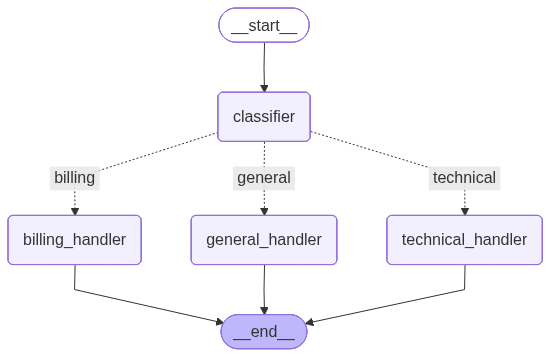

In [8]:
display(Image(support_app.get_graph().draw_mermaid_png()))

In [9]:
for event in support_app.stream(
    {"messages": [HumanMessage(content="I was double-charged on my last invoice")]},
    stream_mode="values",
):
    print(event)


{'messages': [HumanMessage(content='I was double-charged on my last invoice', additional_kwargs={}, response_metadata={}, id='441828d0-1da5-418b-9219-85f66fe79254')]}
About to classify: i was double-charged on my last invoice
{'messages': [HumanMessage(content='I was double-charged on my last invoice', additional_kwargs={}, response_metadata={}, id='441828d0-1da5-418b-9219-85f66fe79254')], 'route': 'billing'}
{'messages': [HumanMessage(content='I was double-charged on my last invoice', additional_kwargs={}, response_metadata={}, id='441828d0-1da5-418b-9219-85f66fe79254'), AIMessage(content='[Billing] Please provide your invoice number and the date of the charge. I will review the details and assist you with the double charge.', additional_kwargs={}, response_metadata={}, id='5a4f036f-f3ba-460e-98ac-f3ca4170449f', tool_calls=[], invalid_tool_calls=[])], 'route': 'billing'}


In [10]:
# Test: billing question
result = support_app.invoke({"messages": [HumanMessage(content="I was double-charged on my last invoice")]})
print(f"Route: {result['route']}")
print(f"Response: {result['messages'][-1].content}")

About to classify: i was double-charged on my last invoice
Route: billing
Response: [Billing] I’m sorry for the inconvenience. Please provide your invoice number and the date of the charges so I can review and assist with the double charge refund.


In [11]:
# Test: technical question
result = support_app.invoke({"messages": [HumanMessage(content="The app crashes when I click the settings button")]})
print(f"Route: {result['route']}")
print(f"Response: {result['messages'][-1].content}")

About to classify: the app crashes when i click the settings button
Route: technical
Response: [Technical] Please provide the following to help debug:
1. The app's platform (iOS, Android, web).
2. Any error messages or logs when the crash occurs.
3. The code or method invoked by the settings button.
4. Whether this started happening after a recent update.


In [12]:
# Test: general question
result = support_app.invoke({"messages": [HumanMessage(content="What are your business hours?")]})
print(f"Route: {result['route']}")
print(f"Response: {result['messages'][-1].content}")

About to classify: what are your business hours?
Route: general
Response: [General] Our business hours are Monday to Friday, 9 AM to 6 PM. How can I assist you today?


## 5. Memory with checkpoints

Without checkpointing, each `invoke` starts with a fresh state. With a **checkpointer**, state persists across invocations using a `thread_id`.

This is how you build multi-turn agents — state persists without manual message management.

In [13]:
from langgraph.checkpoint.memory import MemorySaver
# memory saver for redis, postgres, monogo


# Recompile the support app with a checkpointer
checkpointer = MemorySaver()
support_app_with_memory = graph.compile(checkpointer=checkpointer)

# Thread ID groups related conversations
config = {"configurable": {"thread_id": "user-123"}}

# Turn 1
result1 = support_app_with_memory.invoke(
    {"messages": [HumanMessage(content="I have a billing question about my last charge")]},
    config=config,
)
print(f"Turn 1 — Route: {result1['route']}")
print(f"Turn 1 — Messages: {len(result1['messages'])}")
for msg in result1["messages"]:
    print(f"  {type(msg).__name__}: {msg.content[:80]}...")

About to classify: i have a billing question about my last charge
Turn 1 — Route: billing
Turn 1 — Messages: 2
  HumanMessage: I have a billing question about my last charge...
  AIMessage: [Billing] Please provide the invoice number or the date of the last charge, and ...


In [14]:
# Turn 2 — same thread, conversation continues
result2 = support_app_with_memory.invoke(
    {"messages": [HumanMessage(content="Actually the charge was $49.99, can you look it up?")]},
    config=config,
)
print(f"Turn 2 — Messages: {len(result2['messages'])}")
for msg in result2["messages"]:
    print(f"  {type(msg).__name__}: {msg.content[:100]}")

About to classify: actually the charge was $49.99, can you look it up?
Turn 2 — Messages: 4
  HumanMessage: I have a billing question about my last charge
  AIMessage: [Billing] Please provide the invoice number or the date of the last charge, and specify your questio
  HumanMessage: Actually the charge was $49.99, can you look it up?
  AIMessage: [Billing] Please provide the invoice number or the date of the charge so I can look it up for you.


In [15]:
# Different thread — fresh conversation
config_new = {"configurable": {"thread_id": "user-456"}}
result3 = support_app_with_memory.invoke(
    {"messages": [HumanMessage(content="My app is not working")]},
    config=config_new,
)
print(f"New thread — Messages: {len(result3['messages'])}")
print(f"Route: {result3['route']}")

About to classify: my app is not working
New thread — Messages: 2
Route: technical


## Exercise: Extend the classifier

> **Exercise:** Extend the customer support classifier to handle a **fourth category: "account"** (for messages about login, password, account settings). Add an `account_handler` node with an appropriate system prompt. 
>
> **Bonus:** Add a `fallback_handler` that triggers when the classifier can't confidently categorize (e.g., the message doesn't match any keywords). Test with 4-5 different messages and verify correct routing.
>
> Hints:
> - Add keywords like "login", "password", "account", "username" to the classifier
> - Add a new node and edge to the graph
> - Update the `add_conditional_edges` path map

In [16]:
# YOUR CODE HERE
